<a href="https://colab.research.google.com/github/Edwin1340/CVNLPGA/blob/main/CVNLPASGM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

['Tomato___Early_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___healthy']

Total number of selected classes are:  3

The number of images in Tomato___Early_blight:  1920 
The number of images in Tomato___Tomato_Yellow_Leaf_Curl_Virus:  1961 
The number of images in Tomato___healthy:  1926 
The total images inside the directory:  5807 



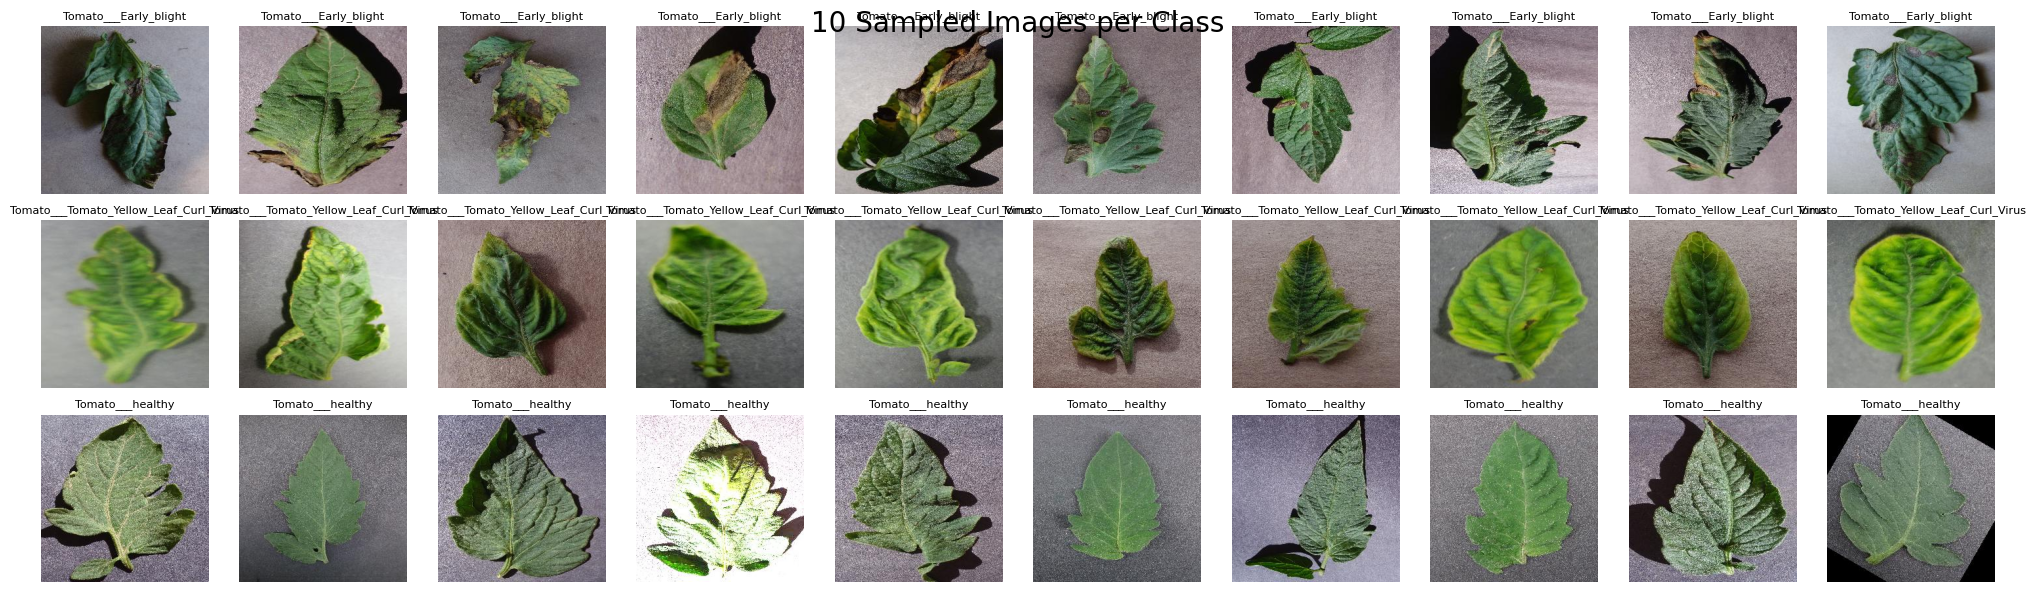

In [10]:
!pip install colorama
!pip install kagglehub
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import random
import matplotlib.pyplot as plt
from colorama import Fore
import kagglehub
import sys
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

Root_dir = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

# Define the training and validation directories based on the provided full path
train_dir = os.path.join(Root_dir, "New Plant Diseases Dataset(Augmented)", "New Plant Diseases Dataset(Augmented)", "train")
valid_dir = os.path.join(Root_dir, "New Plant Diseases Dataset(Augmented)", "New Plant Diseases Dataset(Augmented)", "valid")
test_dir = os.path.join(Root_dir, "New Plant Diseases Dataset(Augmented)", "New Plant Diseases Dataset(Augmented)", "test")

# Define the specific classes to include
Diseases_classes = ["Tomato___Early_blight", "Tomato___Tomato_Yellow_Leaf_Curl_Virus", "Tomato___healthy"]

print(Fore.GREEN + str(Diseases_classes))
print("\nTotal number of selected classes are: ", len(Diseases_classes))

# Set the number of images to display per class
subset_size = 10
cols = 10  # Number of columns for each class grid
rows = len(Diseases_classes)  # Rows per class

# Create a figure to hold all images from each class
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 2), dpi=100) # Creates a space for the image to be displayed, and adjust the size and quality of image

# Loop through each class and plot 10 images in a grid
tot_images = 0
for class_idx, class_name in enumerate(Diseases_classes):
    image_files = os.listdir(train_dir + "/" + class_name) # Loops through each directory
    sampled_files = random.sample(image_files, min(subset_size, len(image_files)))  # Randomly sample 10 images of each directory, scan through the total number of images in each files
    print("\nThe number of images in " + class_name + ": " , len(image_files), end=" ")
    tot_images += len(image_files)

    # Display each image with labels
    for i, img_file in enumerate(sampled_files):
        img_path = os.path.join(train_dir, class_name, img_file) # Holds the main directory, class name, and specific image name ex.(plant1.jpg)
        img_show = plt.imread(img_path)                          # Used to display the specific image

        # Display the image in the grid
        ax = axes[class_idx, i] # Position the images to row and column
        ax.imshow(img_show)     # Display the images
        ax.axis('off')  # Hide axis ticks and labels
        ax.set_title(class_name, fontsize=8)  # Set the label as the class name

print("\nThe total images inside the directory: ", tot_images , "\n")
plt.tight_layout()      # Adjust space between each images (Tidy up the text, images, and labels)
plt.suptitle("10 Sampled Images per Class", fontsize=20)
plt.show()


In [11]:
# Function to preprocess images from directories
def preprocess_images_from_directories(base_dir, class_names, target_size=(128, 128)):
    images = []
    labels = []

    # Loop through each class directory
    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        image_files = os.listdir(class_dir)
        print(f"Processing class '{class_name}' with {len(image_files)} images...")

        # Loop through each image in the class directory
        for img_file in image_files:
            img_path = os.path.join(class_dir, img_file)
            img = load_img(img_path, target_size=target_size)  # Load and resize the image
            img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)  # Add image to list
            labels.append(class_index)  # Add corresponding class index as label

    return np.array(images), np.array(labels)

# Preprocess training images
train_images, train_labels = preprocess_images_from_directories(train_dir, Diseases_classes)

# Preprocess validation images
valid_images, valid_labels = preprocess_images_from_directories(valid_dir, Diseases_classes)


Processing class 'Tomato___Early_blight' with 1920 images...
Processing class 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' with 1961 images...
Processing class 'Tomato___healthy' with 1926 images...
Processing class 'Tomato___Early_blight' with 480 images...
Processing class 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' with 490 images...
Processing class 'Tomato___healthy' with 481 images...


In [12]:
# Print the shapes of the preprocessed datasets
print(f"\nTrain images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation images shape: {valid_images.shape}, Validation labels shape: {valid_labels.shape}")

# Optional: Split the training data further into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

print(f"\nX_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")



Train images shape: (5807, 128, 128, 3), Train labels shape: (5807,)
Validation images shape: (1451, 128, 128, 3), Validation labels shape: (1451,)

X_train shape: (4645, 128, 128, 3), X_test shape: (1162, 128, 128, 3)
y_train shape: (4645,), y_test shape: (1162,)


In [15]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=500,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(layers.Dense(len(Diseases_classes), activation = 'softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = 'sparse_categorical_crossentropy', # Changed to appropriate loss function
              metrics = ['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 126, 126, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 63, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 30, 30, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 500)                 │      12,544,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           1,503 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,833,011 (48.95 MB)

 Trainable params: 12,833,011 (48.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
#               loss = 'sparse_categorical_crossentropy', # Changed to appropriate loss function
#               metrics = ['accuracy']
# )

# Early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Fit the model
history = model.fit(
    X_train,
    y_train,
    epochs=20,  # Number of epochs to train
    batch_size=32,  # Number of samples per gradient update
    validation_data=(X_test, y_test),  # Validation data
    callbacks=[early_stopping, reduce_lr],  # Add callbacks for optimization
    verbose=1  # Display progress during training
)

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))                                                # Specify the width and height of the graph
plt.subplot(1, 2, 1)                                                       # Create a grid with 1 row and 2 column, for placing the graph || Last digits shows the graph placing in the left side
plt.plot(history.history['accuracy'], label='Train Accuracy')              # Plots the training accuracy inside the graph
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')     # Plots the validation accuracy inside the graph
plt.title('Model Accuracy')                                                # Title of the graph
plt.ylabel('Accuracy')                                                     # y-axis label title
plt.xlabel('Epoch')                                                        # x-axis label title
plt.legend(loc='lower right')                                              # Legends located at the lower right

plt.subplot(1, 2, 2)                                                       # Last parameter, "2" shows that this graph will be placing at the right side
plt.plot(history.history['loss'], label='Train Loss')                      # Plot the result of train loss
plt.plot(history.history['val_loss'], label='Validation Loss')             # Plot the result of validation loss
plt.title('Model Loss')                                                    # Title of the graph
plt.ylabel('Loss')                                                         # y-axis label title
plt.xlabel('Epoch')                                                        # x-axis label title
plt.legend(loc='upper right')                                              # Legends located at upper right

plt.tight_layout()                                                         # Adjust the space between each graph (making the text, line, graph more tidy)
plt.show(block=True)                                                       # Display the graph

Epoch 1/20
114/146 ━━━━━━━━━━━━━━━━━━━━ 1:44 3s/step - accuracy: 0.5537 - loss: 0.8439

In [ ]:
train_loss, train_acc = model.evaluate(train_images, train_labels)
print('Training Accuracy: ', train_acc)
print('Training Loss: ', train_loss)

In [ ]:
val_loss, val_acc = model.evaluate(valid_images, valid_labels)
print('Validation Accuracy: ', val_acc)
print('Validation Loss: ', val_loss)

In [ ]:
model.save('Trained_Plant_Diseases_Model.keras')

In [ ]:
history.history

# Evaluation Matrix: Accuracy Evaluation


In [ ]:
epochs = [i for i in range(1, 21)]
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [ ]:
selected_classes = ['Tomato___Early_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___healthy']

test_set = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=selected_classes,  # Specify only the desired classes
    color_mode="rgb",
    batch_size=1,
    image_size=(128, 128),
    shuffle=False,
    interpolation="bilinear",
)


# Prediction

In [ ]:
y_pred = model.predict(test_set)
y_pred, y_pred.shape

In [ ]:
predicted_categories = tf.argmax(y_pred, axis = 1)
predicted_categories

In [ ]:
true_categories = tf.concat([y for x,y in test_set], axis = 0)
true_categories

In [ ]:
Y_true = tf.argmax(true_categories, axis = 1)
Y_true

# Evaluation Matrics: Precision, Recalll, F1-Score

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(Y_true, predicted_categories, target_names = selected_classes))

# Confusion Matrices

In [ ]:
conf_matr = confusion_matrix(Y_true, predicted_categories)
conf_matr

In [ ]:
# Define your class names
class_names = ["Tomato___Early_blight", "Tomato___Tomato_Yellow_Leaf_Curl_Virus", "Tomato___healthy"]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matr, annot=True, fmt="d", annot_kws={'size': 15}, xticklabels=class_names, yticklabels=class_names)

# Set axis labels and title
plt.xlabel("Predicted Class", fontsize=20)
plt.ylabel("Actual Class", fontsize=20)
plt.title("Tomato Plant Confusion Matrix", fontsize=20)

# Rotate tick labels for better visibility
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=45, fontsize=12)

# Show the plot
plt.show()
